
⭐ **This script is originally by Chip Huyen and is available at:**

https://github.com/chiphuyen/aie-book/blob/main/scripts/ai-heatmap.ipynb


It was modified to work on Google Colab, to include a word cloud, and to generate the final chart combining the heat map and the word cloud, as well as minor comments.

**How to use this script**
1. Export your ChatGPT conversations. From your ChatGPT account, go to Settings -> Data controls -> Export
2. Unzip the data export
3. Point `convo_folder` to your exported data folder (at your Google Drive)
4. Change `local_tz` to your local timezone so that it gets the correct timestamp of each conversation.

## Importing Libraries

In [43]:
!pip install pytz matplotlib numpy
!pip install googletrans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00


In [48]:
import json
import pytz
from datetime import datetime, timezone, timedelta
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from googletrans import Translator
import asyncio


## Accessing the File

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
convo_folder = '/content/drive/My Drive/gptdados'
# change to where your exported ChatGPT folder is on Google Drive

local_tz = 'America/Sao_Paulo' # change to your local timezone.
# pytz.all_timezones # uncomment to see a list of all supported timezones.

## Generating HeatMap

In [6]:
with open(f'{convo_folder}/conversations.json', 'r') as f:
    convs = json.load(f)

In [7]:
convo_times = []
for conv in convs:
    # Given Unix timestamp
    unix_timestamp = conv['create_time']

    # Convert to UTC datetime
    utc_datetime = datetime.fromtimestamp(unix_timestamp, tz=timezone.utc)

    # Convert UTC datetime to local timezone
    pt_datetime = utc_datetime.astimezone(pytz.timezone(local_tz))
    convo_times.append(pt_datetime)

In [8]:
def create_year_heatmap(convo_times, year):
    # Convert convo_times to dates and filter for the given year
    just_dates = [convo.date() for convo in convo_times if convo.year == year]

    date_counts = Counter(just_dates)

    # Create a full year date range for the calendar
    start_date = datetime(year, 1, 1).date()
    end_date = datetime(year, 12, 31).date()

    total_days = (end_date - start_date).days + 1
    date_range = [start_date + timedelta(days=i) for i in range(total_days)]

    # Prepare data for plotting
    data = []
    for date in date_range:
        week = ((date - start_date).days + start_date.weekday()) // 7
        day_of_week = date.weekday()
        count = date_counts.get(date, 0)
        data.append((week, day_of_week, count))

    weeks_in_year = (end_date - start_date).days // 7 + 1

    # Plot the heatmap
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')

    max_count_date = max(date_counts, key=date_counts.get)
    max_count = date_counts[max_count_date]
    p90_count = np.percentile(list(date_counts.values()), 90)
    for week, day_of_week, count in data:
        color = plt.cm.Greens((count + 1) / p90_count) if count > 0 else 'lightgray'
        rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    # Replace week numbers with month names below the heatmap
    month_starts = [start_date + timedelta(days=i) for i in range(total_days)
                    if (start_date + timedelta(days=i)).day == 1]
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        plt.text(week + 0.5, 7.75, month_start.strftime('%b'), ha='center', va='center', fontsize=10, rotation=0)

    # Adjustments for readability
    ax.set_xlim(-0.5, weeks_in_year + 0.5)
    ax.set_ylim(-0.5, 8.5)
    plt.title(
        f'{year} ChatGPT Conversation Heatmap (total={sum(date_counts.values())}).\nMost active day: {max_count_date} with {max_count} convos.',
        fontsize=16
    )
    plt.xticks([])
    plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.gca().invert_yaxis()
    plt.show()

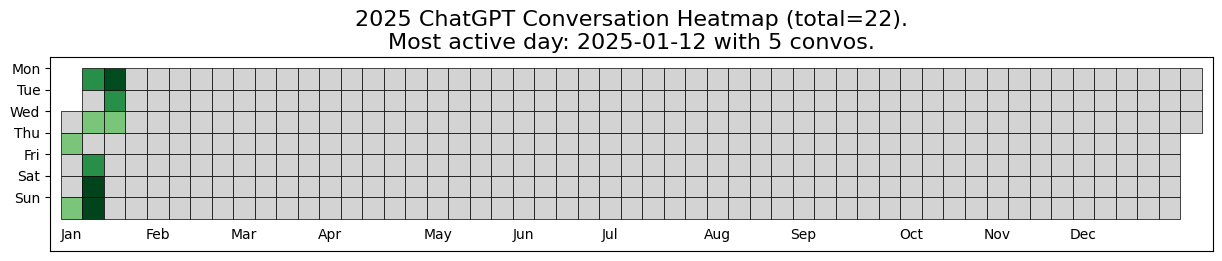

In [9]:
create_year_heatmap(convo_times, 2025)

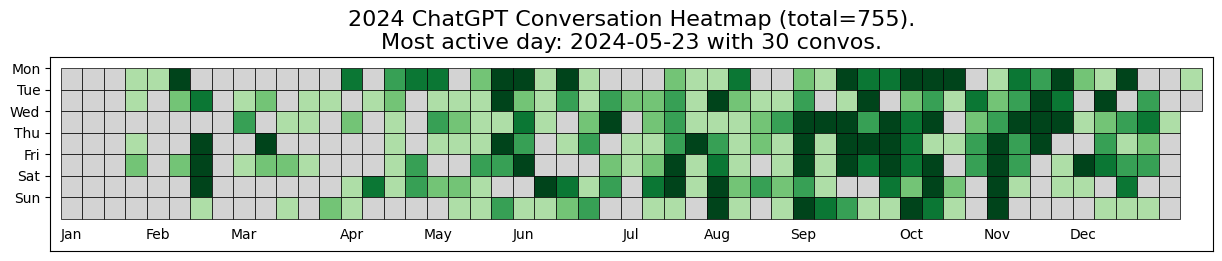

In [10]:
create_year_heatmap(convo_times, 2024)

## Generating WordCloud

In [56]:
titles = []
for conv in convs:
    titles.append(conv['title'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 1.0, 'Most Common Conversations with ChatGPT')

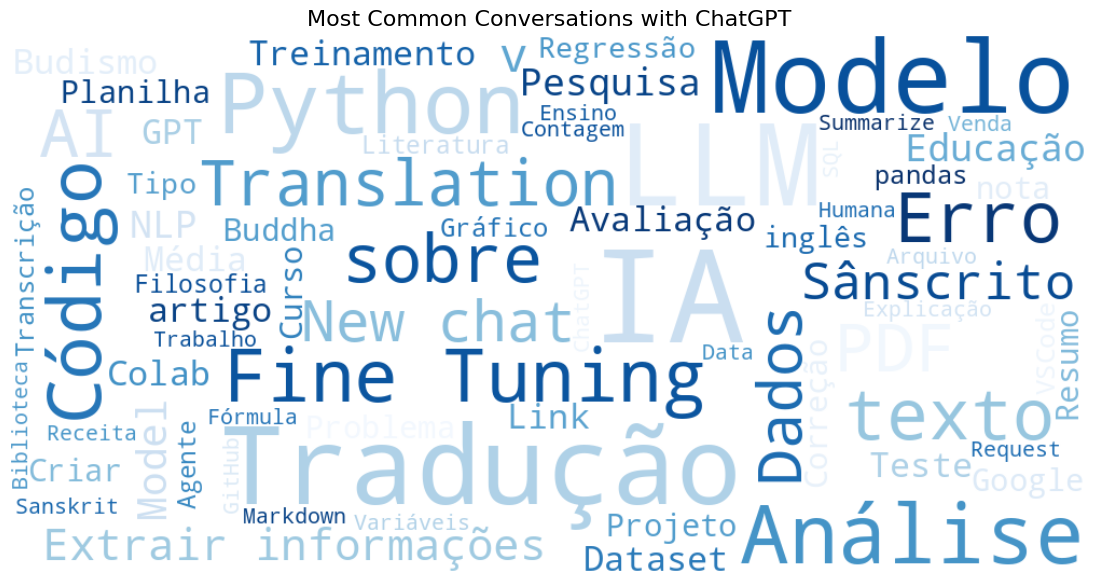

In [64]:
# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Stopwords in English and Portuguese (works for both)
english_stopwords = set(stopwords.words('english'))
portuguese_stopwords = set(stopwords.words('portuguese'))

# Combine stopwords from both languages
all_stopwords = english_stopwords.union(portuguese_stopwords)

# Join all titles into a single string
text = " ".join(titles)

# Generate the word cloud
wordcloud = WordCloud(
    width=1000,              # Adjust width
    height=500,              # Adjust height
    background_color='white',  # Change background
    colormap='Blues',       # Change colormap
    max_words=250,           # Change the number of words
    stopwords=all_stopwords,  # Remove stopwords
    relative_scaling=0.8,  # Adjust relative scaling
    max_font_size=120,
    min_font_size=20,
    prefer_horizontal=0.75,   # Prioritize horizontal words
    contour_width=0.5,
    contour_color='gray'      # Adjustcontour
).generate(text)

# Plot the word cloud
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Conversations with ChatGPT", fontsize=16, color='black')

## Generating a unique visualization of the HeatMap and WordCloud

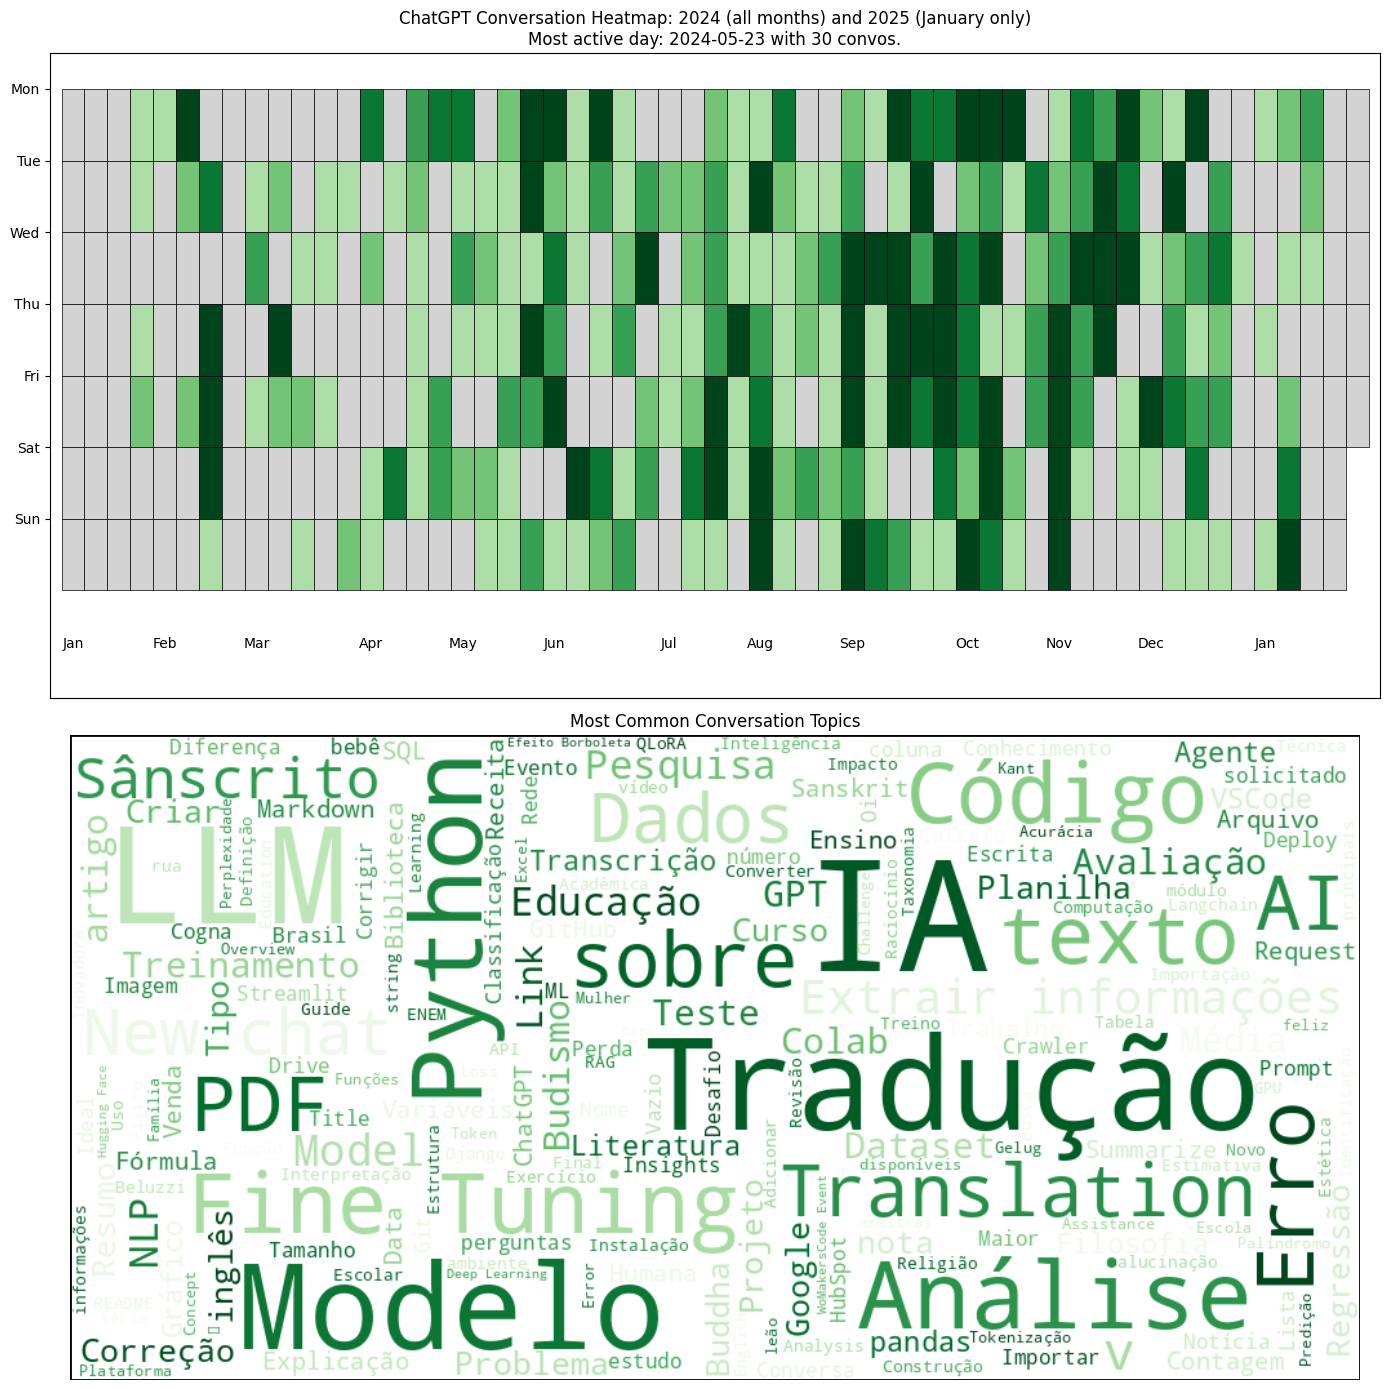

In [79]:
# Stopwords in English and Portuguese
english_stopwords = set(stopwords.words('english'))
portuguese_stopwords = set(stopwords.words('portuguese'))
all_stopwords = english_stopwords.union(portuguese_stopwords)

# Join all titles into a single string
text = " ".join(titles)

# Generate the word cloud
wordcloud = WordCloud(
    width=1000,              # Adjust width
    height=500,              # Adjust height
    background_color='white',  # Change background
    colormap='Greens',       # Change colormap
    max_words=350,           # Change the number of words
    stopwords=all_stopwords,  # Remove stopwords
    relative_scaling=0.85,  # Adjust relative scaling
    max_font_size=120,
    min_font_size=10,
    prefer_horizontal=0.75,   # Prioritize horizontal words
    contour_width=0.5,
    contour_color='darkgreen'      # Adjustcontour
).generate(text)

# Function to create a heatmap
def create_filtered_year_heatmap(convo_times, year1, year2, ax):
    # Filter dates for year1 (all months) and year2 (only January by default)
    # To adjust months for year2, modify the condition (e.g., convo.month <= 3 for Jan-Mar)
    just_dates = [
        convo.date() for convo in convo_times
        if (convo.year == year1) or (convo.year == year2 and convo.month == 1)
    ]

    date_counts = Counter(just_dates)

    start_date = datetime(year1, 1, 1).date()
    end_date = datetime(year2, 1, 31).date()
    total_days = (end_date - start_date).days + 1
    date_range = [start_date + timedelta(days=i) for i in range(total_days)]

    data = []
    for date in date_range:
        week = ((date - start_date).days + start_date.weekday()) // 7
        day_of_week = date.weekday()
        count = date_counts.get(date, 0)
        data.append((week, day_of_week, count))

    weeks_in_range = (end_date - start_date).days // 7 + 1

    # Plot the heatmap
    max_count_date = max(date_counts, key=date_counts.get)
    max_count = date_counts[max_count_date]
    p90_count = np.percentile(list(date_counts.values()), 90)
    for week, day_of_week, count in data:
        color = plt.cm.Greens((count + 1) / p90_count) if count > 0 else 'lightgray'
        rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    # Replace week numbers with month names below the heatmap
    month_starts = [start_date + timedelta(days=i) for i in range(total_days)
                    if (start_date + timedelta(days=i)).day == 1]
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        ax.text(week + 0.5, 7.75, month_start.strftime('%b'), ha='center', va='center', fontsize=10, rotation=0)

    # Adjustments for readability
    ax.set_xlim(-0.5, weeks_in_range + 0.5)
    ax.set_ylim(-0.5, 8.5)
    ax.set_title(
        f'ChatGPT Conversation Heatmap: {year1} (all months) and {year2} (January only)\n'
        f'Most active day: {max_count_date} with {max_count} convos.',
        fontsize=12
    )
    ax.set_xticks([])
    ax.set_yticks(range(7))
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax.invert_yaxis()


# Create a combined visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Plot the heatmap on the first axis
create_filtered_year_heatmap(convo_times, 2024, 2025, axes[0])

# Plot the word cloud on the second axis
axes[1].imshow(wordcloud, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title(
    "Most Common Conversation Topics",
    fontsize=12,
    color='black'
)

# Add a border around the word cloud
frame_color = 'black'  # Customize the frame color
frame_width = 2  # Customize the frame width
axes[1].add_patch(plt.Rectangle(
    (0, 0), 1, 1, transform=axes[1].transAxes,
    linewidth=frame_width,
    edgecolor=frame_color,
    facecolor='none'
))

plt.tight_layout()
plt.show()